In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../../")

from experiment import Exp

from dataloaders import data_set,data_dict
import torch
import yaml
import os

import torch
from ptflops import get_model_complexity_info

In [2]:
torch.__version__

'1.13.1+cu117'

In [3]:
import brevitas
brevitas.__version__

'0.9.2.dev2+g9bb26bf'

# Parameter settings

# Training parameters

In [4]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict()   
# TODO change the path as relative path
args.to_save_path     = r"../../Run_logs"            
args.freq_save_path   = r"../../Freq_data"
args.window_save_path = r"../../Sliding_window"
args.root_path        = r"../../datasets"


args.drop_transition  = False
args.datanorm_type    = "standardization" # None ,"standardization", "minmax"


args.batch_size       = 256                                                     
args.shuffle          = True
args.drop_last        = False
args.train_vali_quote = 0.90                                           


# training setting 
args.train_epochs            = 150

args.learning_rate           = 0.001  
args.learning_rate_patience  = 7
args.learning_rate_factor    = 0.1


args.early_stop_patience     = 15

args.use_gpu                 = True if torch.cuda.is_available() else False
args.gpu                     = 0
args.use_multi_gpu           = False

args.optimizer               = "Adam"
args.criterion               = "CrossEntropy"

## Data parameters



In [5]:
# oppo : 25/50  2
# dg   : 12/24  4
# dsads: 12/24  4
# pamap2: 10/20  5
# wisdm: 12/24  4
# skodar : 12/24 4

In [6]:
args.seed                             = 1


args.data_name                        =  "pamap2"

args.wavelet_filtering                = False
args.wavelet_filtering_regularization = False
args.wavelet_filtering_finetuning     = False
args.wavelet_filtering_finetuning_percent = 0.5
args.wavelet_filtering_learnable      = False
args.wavelet_filtering_layernorm      = False

args.regulatization_tradeoff          = 0
args.number_wavelet_filtering         = 12


args.difference       = False 
args.filtering        =  False
args.magnitude        =  False
args.weighted_sampler = False




args.pos_select       = None
args.sensor_select    = None


args.representation_type = "time"
args.exp_mode            = "LOCV"
if args.data_name      ==  "skodar":
    args.exp_mode            = "SOCV"
config_file = open('../../configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]

args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
args.num_classes     =  config["num_classes"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.input_length    =  args.windowsize
# input information
args.c_in            = config["num_channels"]


if args.difference:
    args.c_in = args.c_in*2

if args.wavelet_filtering :
    
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1



## Model parameters

In [7]:
# dsads 27838817.0 99367   26
# skodar  9907786.0   67092 24
# wisdm 733382.0 16
# dg  1041602.0 16
# oppo 7377290.0 28

In [8]:
# 如果我们设置为 


args.model_type              = "tinyhar"#"deepconvlstm"#"sahar" #"deepconvlstm"

args.cross_channel_interaction_type = "attn"
args.cross_channel_aggregation_type = "FC"
args.temporal_info_interaction_type = "conv"
args.temporal_info_aggregation_type = "tnaive"

exp = Exp(args)

Use GPU: cuda:0
Build the TinyHAR model!
Done!
Parameter : 40008
Set the seed as :  1


exp.

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------
================ LOCV Mode ====================
================ 9 CV ======================
================ the 0 th CV Experiment ================ 
Leave one Out Experiment : The 1 Part as the test
[-] Target sampling weights:  [0.00171233 0.00170358 0.0016835  0.001287   0.00362319 0.00200401
 0.00166113 0.0028169  0.00308642 0.00182815 0.00129366 0.00775194]
Train data number :  6047
The number of classes is :  12
The input_length  is :  168
The channel_in is :  18
Validation data number :  672
Test data number :  5207
================ Build the model ================ 
Build the TinyHAR model!
Epoch: 1 cost time: 42.39201736450195
VALI: Epoch: 1, Steps: 24 | Train Loss: 2.2996342  Vali Loss: 2.1137218 Vali Accuracy: 0.2827381  Vali weighted F1: 0.1631436  Vali macro F1 0.13

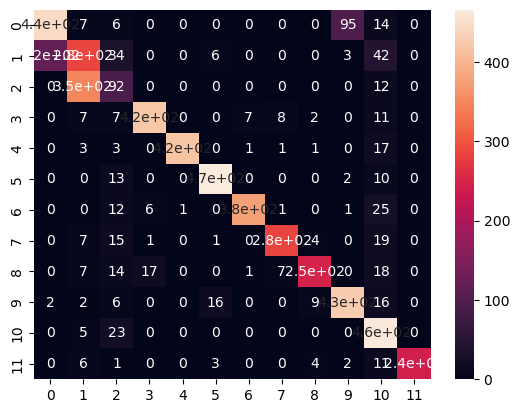

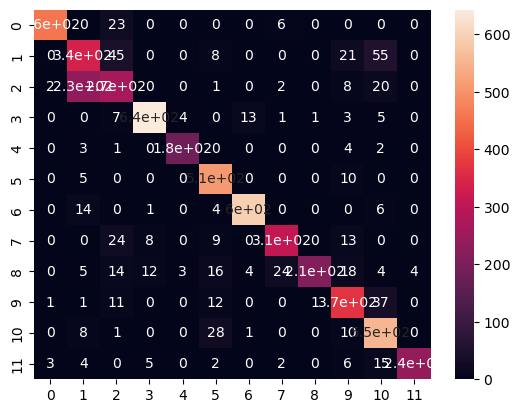

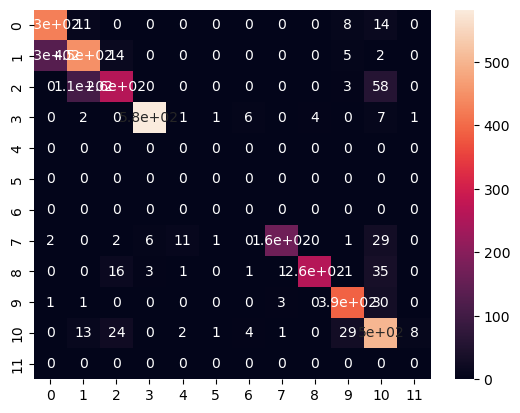

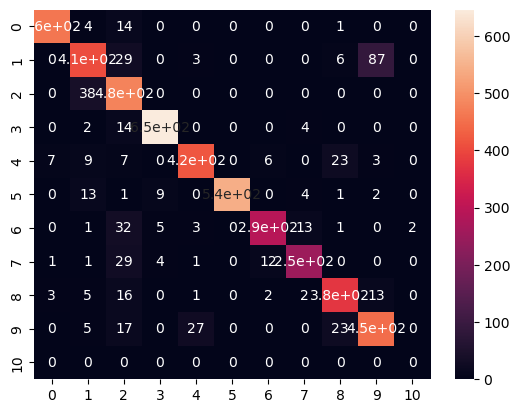

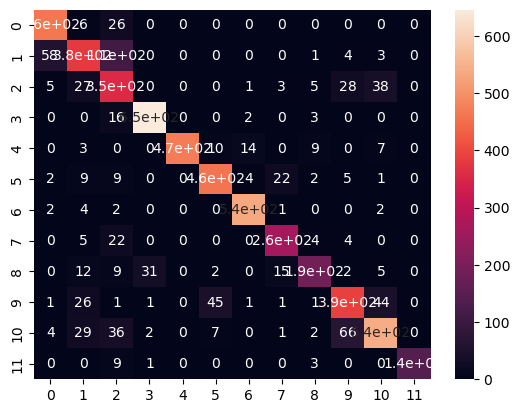

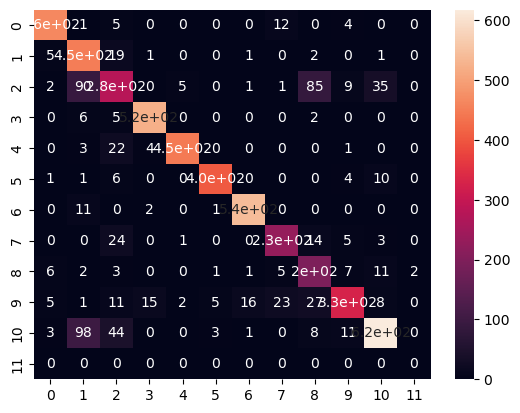

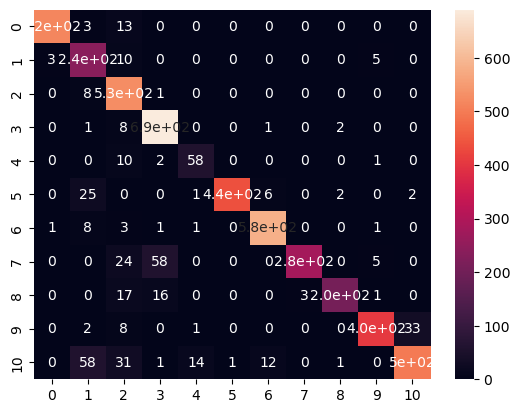

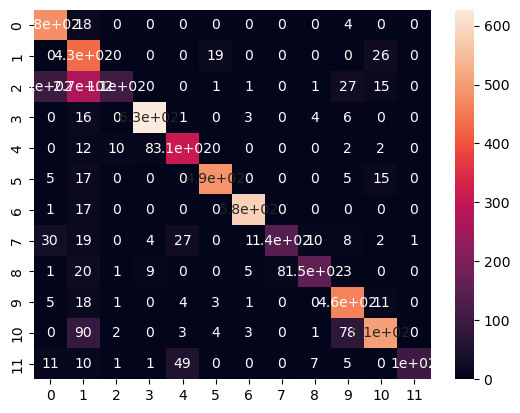

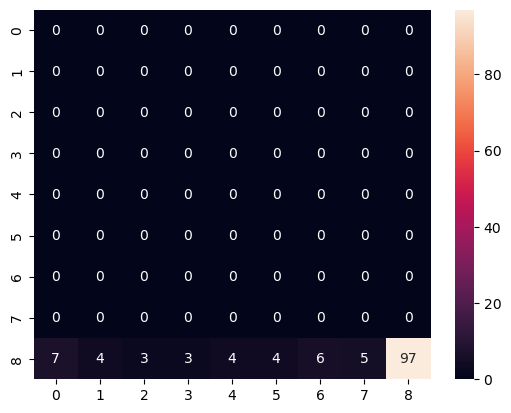

In [9]:
exp.train()

#onnx export
import torch
import brevitas.onnx as bo
from brevitas.quant_tensor import QuantTensor

num_classes = 12
num_channels =18
windowsize = 168
data_usage = torch.randn(1, 1, windowsize, num_channels)
data_usage = data_usage.double

ready_model_filename = "tiny_proto.onnx"

# Export to ONNX
#Move to CPU before export
model = exp.model

bo.export_finn_onnx(
    model, input_t=data_usage, export_path=ready_model_filename
)

In [ ]:
macs, params = get_model_complexity_info(exp.model, (1  ,args.input_length,args.c_in), as_strings=False,
                                       print_per_layer_stat=True, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [ ]:
args.filter_scaling_factor =1
args.model_type              = "mcnn"#"deepconvlstm"#"sahar" #"deepconvlstm"  "deepconvlstm_attn"
exp = Exp(args)
#exp.model

In [ ]:



macs, params = get_model_complexity_info(exp.model, (1  ,args.input_length,args.c_in), as_strings=False,
                                       print_per_layer_stat=True, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [ ]:
exp.train()

model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

## export

In [ ]:
#TODO: set para from config

 if self.args.model_type == "mcnn":
            config_file = open('../../configs/model.yaml', mode='r')
            config = yaml.load(config_file, Loader=yaml.FullLoader)["mcnn"]
            setting = "mcnn_data_{}_seed_{}_windowsize_{}_waveFilter_{}_Fscaling_{}_cvfilter_{}_Regu_{}_wavelearnble_{}".format(self.args.data_name,
                                                                                                                                              self.args.seed,
                                                                                                                                              self.args.windowsize,
                                                                                                                                              self.args.wavelet_filtering,
                                                                                                                                              self.args.filter_scaling_factor,
                                                                                                                                              config["nb_filters"],
                                                                                                                                              self.args.wavelet_filtering_regularization,
                                                                                                                                              self.args.wavelet_filtering_learnable )
            return setting


pamap2:
  filename: "PAMAP2_Dataset/Protocol"
  sampling_freq: 33
  num_classes: 12
  num_channels: 18
  window_seconds: 5.12
  
self.model  = MCNN((1,f_in, self.args.input_length, self.args.c_in ), 
                                self.args.num_classes,
                                self.args.filter_scaling_factor,
                                config)
(1,1,169,18) 12, 1
f_in = 1
args.windowsize      =   int(window_seconds * args.sampling_freq) 
                     = 169
args.filter_scaling_factor =1                     

args.root_path       = os.path.join(args.root_path,config["filename"])
args.sampling_freq   = config["sampling_freq"]
args.num_classes     =  config["num_classes"]
window_seconds       = config["window_seconds"]
args.windowsize      =   int(window_seconds * args.sampling_freq) 
args.input_length    =  args.windowsize
# input information
args.c_in            = config["num_channels"]

In [ ]:
from models.TinyHAR import TinyHAR_Model

In [ ]:
num_classes = 12
num_channels =18
windowsize = 168
input_shape =(1, 1, windowsize, num_channels)
print(input_shape)
config_file = open('../../configs/model.yaml', mode='r')
config = yaml.load(config_file, Loader=yaml.FullLoader)["tinyhar"]


In [ ]:
model = TinyHAR_Model(input_shape = input_shape,
                      number_class = num_classes,
                      filter_num = 20,
                      cross_channel_interaction_type = "attn",
                      cross_channel_aggregation_type = "FC",
                      temporal_info_interaction_type = "conv",
                      temporal_info_aggregation_type = "tnaive")

In [ ]:
loadPath ="/home/bian/finn/notebooks/HAR/Run_logs/logs/tinyhar_data_pamap2_seed_1_windowsize_168_cvfilter_20_CI_attn_CA_FC_TI_conv_TA_tnaive/cv_6/final_best_vali.pth"

model.load_state_dict(torch.load(loadPath),strict=False)
model.eval()

In [ ]:
import torch
import brevitas.onnx as bo


ready_model_filename = "tiny_identity_tnaive.onnx"

# Export to ONNX
#Move to CPU before export
model.cpu()
inp = torch.randn(1,1,168,18)
#input_shape = (1,1,168,18)
bo.export_finn_onnx(model, inp, ready_model_filename)
"""
torch.onnx.export(model, 
                  data_usage, 
                  ready_model_filename,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file         # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'] # the model's output names
                  )
"""
print("Model saved to %s" % ready_model_filename)

In [ ]:
import torch
from brevitas.export import export_onnx_qcdq


ready_model_filename = "tiny_identity_v2.onnx"

# Export to ONNX
#Move to CPU before export
model.cpu()
inp = torch.randn(1,1,168,18)
#input_shape = (1,1,168,18)
exported_model = export_onnx_qcdq(model, args=inp, export_path=ready_model_filename,opset_version=13)
"""
torch.onnx.export(model, 
                  data_usage, 
                  ready_model_filename,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file         # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'] # the model's output names
                  )
"""
print("Model saved to %s" % ready_model_filename)

In [ ]:
from skl2onnx.helpers.onnx_helper import load_onnx_model
from skl2onnx.helpers.onnx_helper import enumerate_model_node_outputs

model_onnx = load_onnx_model("tiny_identity.onnx")
for out in enumerate_model_node_outputs(model_onnx):
    print(out)

from skl2onnx.helpers.onnx_helper import save_onnx_model
from skl2onnx.helpers.onnx_helper import select_model_inputs_outputs
num_onnx = select_model_inputs_outputs(model_onnx, '/Transpose_output_0')
save_onnx_model(num_onnx, "identify_before_transpose.onnx")

import onnx
onnx_model = onnx.load("tiny_proto.onnx")
onnx.checker.check_model(onnx_model)

In [ ]:
# cross_channel_interaction_type = "attn",    # attn  transformer  identity
# cross_channel_aggregation_type = "filter",  # filter  naive  FC  "SFCC", "SFCF"
# temporal_info_interaction_type = "gru",     # gru  lstm  attn  transformer  identity  conv
# temporal_info_aggregation_type = "FC",      # naive  filter  FC  tnaive

# 实验

In [ ]:
# 如果我们设置为 


args.model_type              = "tinyhar"#"deepconvlstm"#"sahar" #"deepconvlstm"

args.cross_channel_interaction_type = "attn"
args.cross_channel_aggregation_type = "FC"
args.temporal_info_interaction_type = "lstm"
args.temporal_info_aggregation_type = "tnaive"

exp = Exp(args)

In [ ]:
exp.model

In [ ]:
exp.train()

In [ ]:
dataset = data_dict[args.data_name](args)

In [ ]:
import numpy as np

In [ ]:
start_index = dataset.train_slidingwindows[0][1]
end_index   = dataset.train_slidingwindows[0][2]
sample_x_1    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

start_index = dataset.train_slidingwindows[100][1]
end_index   = dataset.train_slidingwindows[100][2]
sample_x_2    = dataset.data_x.iloc[start_index:end_index, 1:-1].values

temp_1 = np.expand_dims(sample_x_1,0)
temp_2 = np.expand_dims(sample_x_2,0)
combined_x = np.concatenate([temp_1,temp_2],axis=0)
combined_x = np.expand_dims(combined_x,1)
combined_x = torch.tensor(combined_x).double().to(exp.device)
print(combined_x.shape)

In [ ]:
out = exp.model(combined_x)
out = out.cpu().detach().numpy()

In [ ]:
out.shape

In [ ]:
weight = exp.model.wave_conv.wavelet_conv.weight.cpu().detach().numpy()

In [ ]:
for n,p in exp.model.named_parameters():
    print(n)

In [ ]:
import matplotlib.pyplot as plt
index1 = 0
index2 = 0

plt.figure()
plt.plot(out[0,0,:,index2])
plt.plot(out[0,1,:,index2])
plt.plot(out[0,2,:,index2])
plt.plot(out[0,3,:,index2])

In [ ]:
# 如果我们设置为 
# args.wavelet_filtering_learnable      = True
# exp = Exp(args)